In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


<module 'tools' from '/home/ec2-user/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [3]:
cpu_count()

16

### Begin

In [4]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/clean_10yr_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0007.HK,0008.HK,0010.HK,0011.HK,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,59.858372,42.464977,5.838195,8.589485,49.812798,27.253111,0.75,1.905828,41.102428,83.984497,...,6.521324,1.048637,13.701911,13.843930,2.338585,0.45159,1.156469,2.118294,1.380821,0.266212
2011-01-04,60.620258,42.232571,5.850851,8.603373,49.968369,27.280636,0.73,1.922302,41.141720,83.855309,...,6.826671,1.048637,13.493793,14.016541,2.355491,0.45159,1.184907,2.111633,1.417399,0.268489
2011-01-05,61.286934,42.431778,5.844519,8.506300,51.181801,27.308163,0.72,1.894841,41.338200,85.341171,...,6.870292,1.048637,13.528478,14.051094,2.338585,0.43869,1.197547,2.198230,1.417399,0.266144


In [5]:
train_start = '2011-01-01'
train_end = '2011-12-31'
dataset = dataset[train_start:train_end]

In [6]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)

### Fina the NaN in comb_df

In [7]:
comb_df.dropna(axis=0, how='any', inplace=True)

In [8]:
comb_df.tail(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-28,0.012451,0.002274,0.007808,0.011281,0.014316,0.003512,-0.029853,0.054347,0.042260,0.007547,...,-0.048374,0.005141,-0.002238,-0.017483,-0.020762,-0.057175,0.000000,-0.013129,-0.007435,0.000000
2011-12-29,0.004829,-0.007599,-0.001112,-0.025573,-0.010084,0.006987,-0.015268,-0.003839,-0.005764,-0.004845,...,-0.014685,0.005115,-0.009009,-0.008854,0.000000,-0.060644,-0.020495,-0.013304,-0.030305,0.000000
2011-12-30,-0.009142,-0.000763,-0.006697,-0.004321,-0.013606,-0.008741,0.000000,0.041437,0.009206,-0.003243,...,-0.002963,0.000000,0.011247,-0.002545,0.000000,0.459543,-0.017911,-0.018019,0.015268,0.013247


In [9]:
comb_df.head(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.012648,-0.005488,0.002165,0.001615,0.003118,0.001009,-0.027029,0.008607,0.000955,-0.001539,...,0.006369,0.000000,0.002567,0.002462,-0.007203,-0.028982,0.010612,0.040191,0.000000,-0.008772
2011-01-06,0.010938,0.004706,-0.001083,-0.011347,0.023994,0.001009,-0.013793,-0.014388,0.004764,0.017564,...,0.015748,0.056834,-0.033907,0.000000,0.002407,0.000000,-0.017302,-0.021440,-0.006473,0.008268
2011-01-07,0.021523,0.004684,-0.014168,0.004068,0.005456,-0.002018,0.013793,0.014388,0.006632,-0.000757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063791


In [10]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [11]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    return data

### Compare linear regression for 2 selected stocks

In [ ]:
prev_stock = '6190.HK.prev'
today_stock = '0247.HK'
prevday_returns[prev_stock]
today_returns[today_stock]

In [ ]:
prevday_returns

### Non parallel processing

In [ ]:
%%time
catstocks = new_col
catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
results = [get_linear_regression(pair, prevday_returns, today_returns) for pair in pair_list]
result_df = pd.DataFrame(results)
result_df

### Parrallel processing

In [12]:
%%time
catstocks = new_col
# catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
cpu = cpu_count()
print('cpu count = {}'.format(cpu))
executor = Parallel(n_jobs=cpu, backend='multiprocessing')
tasks = (delayed(get_linear_regression)(pair, prevday_returns, today_returns) for pair in pair_list)
results = executor(tasks)
result_df = pd.DataFrame(results)
result_df

cpu count = 16


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwar

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return

CPU times: user 2min 1s, sys: 5.3 s, total: 2min 7s
Wall time: 22min 33s


,Prev,Today,Params,TValues,RSquared
0,0001.HK.prev,0002.HK,-0.055490,1.755292,0.012623
1,0001.HK.prev,0003.HK,-0.045167,1.209346,0.006032
2,0001.HK.prev,0004.HK,0.139309,1.759146,0.012678
3,0001.HK.prev,0005.HK,0.019990,0.324714,0.000437
4,0001.HK.prev,0006.HK,-0.049206,1.234255,0.006281
...,...,...,...,...,...
504805,6823.HK.prev,3988.HK,-0.005430,0.657776,0.001792
504806,6823.HK.prev,3989.HK,-0.038379,1.744548,0.012471
504807,6823.HK.prev,3993.HK,0.018803,1.509948,0.009372
504808,6823.HK.prev,3998.HK,0.014848,1.119126,0.005170


In [13]:
result_df

,Prev,Today,Params,TValues,RSquared
0,0001.HK.prev,0002.HK,-0.055490,1.755292,0.012623
1,0001.HK.prev,0003.HK,-0.045167,1.209346,0.006032
2,0001.HK.prev,0004.HK,0.139309,1.759146,0.012678
3,0001.HK.prev,0005.HK,0.019990,0.324714,0.000437
4,0001.HK.prev,0006.HK,-0.049206,1.234255,0.006281
...,...,...,...,...,...
504805,6823.HK.prev,3988.HK,-0.005430,0.657776,0.001792
504806,6823.HK.prev,3989.HK,-0.038379,1.744548,0.012471
504807,6823.HK.prev,3993.HK,0.018803,1.509948,0.009372
504808,6823.HK.prev,3998.HK,0.014848,1.119126,0.005170


In [14]:
result_df.to_csv('../data/10yr_regression_pair.csv')

### Read Regression Result

In [15]:
result_df = pd.read_csv('../data/10yr_regression_pair.csv', index_col=0)

In [16]:
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
106223,0266.HK.prev,0952.HK,2.637893,12.012917,0.374530
79435,0202.HK.prev,2323.HK,0.319674,10.792716,0.325842
504446,6823.HK.prev,0720.HK,-0.164456,10.635044,0.319409
146711,0373.HK.prev,1003.HK,1.269368,10.366868,0.308409
94429,0237.HK.prev,6823.HK,4.017138,8.961810,0.249955
100645,0252.HK.prev,1223.HK,0.355493,8.581045,0.234031
100294,0252.HK.prev,0335.HK,0.531830,7.466439,0.187862
110674,0273.HK.prev,2319.HK,0.088088,7.230479,0.178259
51850,0128.HK.prev,0026.HK,0.084212,7.148107,0.174927
110307,0273.HK.prev,0526.HK,-0.140535,6.826599,0.162038


### Analyze the Top pair

0266.HK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total prev stock rise 32
Total prev stock rise and today rise 12


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


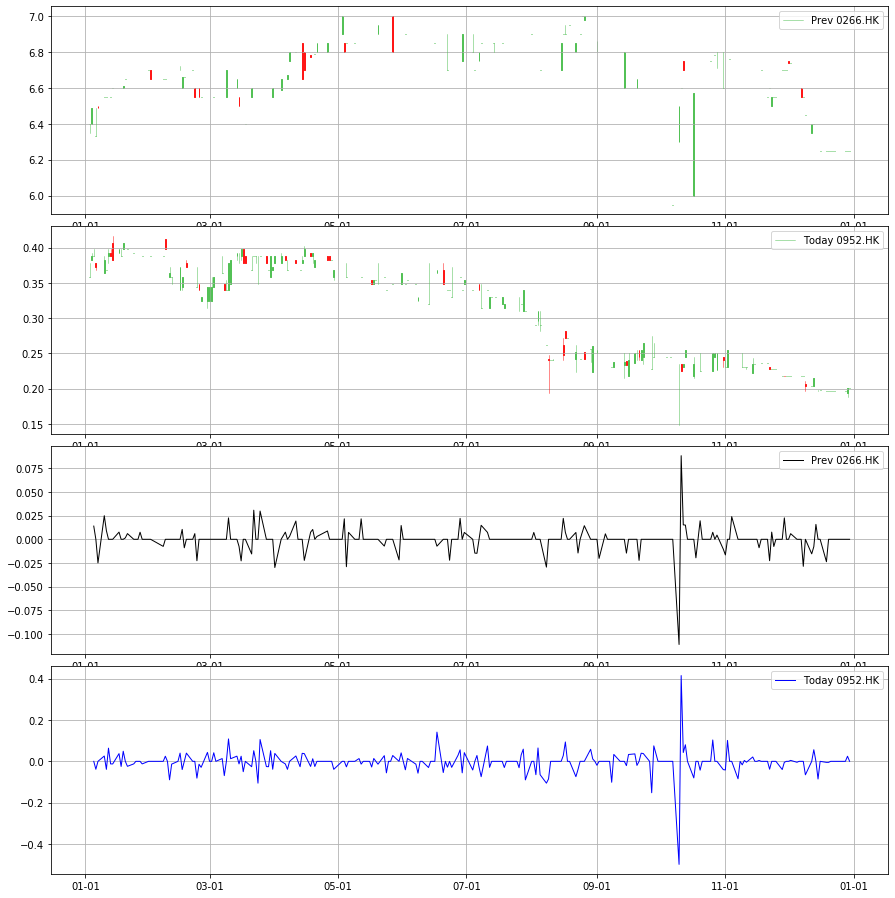

In [18]:
stock1 = '0266.HK.prev'
stock2 = '0952.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, train_start, train_end)

### Upload to AWS S3

In [19]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.upload_data_to_s3(s3_bucket, local_path)

### Verify Linear regression

    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }

In [ ]:
prevday_returns[stock1]

In [ ]:
today_returns[stock2]

In [ ]:
X = prevday_returns[stock1].copy()
X = sm.add_constant(X)
y = today_returns[stock2]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))